# Simple L-System for Space Engineers

Uses the PCGSEPy library included in this repository.

**NOTE**: Have the game *running*; leaving the game simply paused breaks the API (no calls are accepted). *Suggestion*: Use windowed mode, press `Start` after the scenario is loaded and return to this notebook.

Import required packages

In [9]:
import numpy as np

from enum import Enum, auto
from typing import List, Dict, Any

from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
from pcgsepy.structure import *

## Simple L-system

A simple L-system to generate a structure using rules.

Characters used in the expansion string:
- `B`/`b`: Small armor block
- `C`/`c`: Cockpit
- `E`/`e`: Engine
- `t`: Thruster
- `[` and `]`]: Push and pop current coordinate
- `+`: Move forward along `x`
- `-`: Move backward along `x`
- `!`: Move forward along `y`
- `?`: Move backward along `y`
- `>`: Move forward along `z`
- `<`: Move backward along `z`

In [10]:
alphabet = 'BbCcEet[]+-!?><'

### L Parser class.

Expansion and production methods transform the initial axiom using the provided rules for a number `n` of iterations.

**NOTE**: Rules can have multiple characters in the *RHS*, which allows for more complex axioms. Rules are stochastic (i.e.: $LHS \rightarrow p(RHS | LHS$); to make a rule deterministic simply use a single $LHS \rightarrow RHS$ with $p=1.$.

In [11]:
class StochasticRules:
    def __init__(self):
        self._rules = {}
    
    def add_rule(self,
                 lhs: str,
                 rhs: str,
                 p: float) -> None:
        if lhs in self._rules.keys():
            self._rules[lhs][0].append(rhs)
            self._rules[lhs][1].append(p)
        else:
            self._rules[lhs] = ([rhs], [p])
    
    def rem_rule(self,
                 lhs: str) -> None:
        self._rules.pop(lhs)
    
    def get_lhs(self) -> List[str]:
        return self._rules.keys()
    
    def get_rhs(self,
                lhs: str) -> str:
        rhs, p = self._rules[lhs]
        return np.random.choice(rhs, 1, p)[0]
    
    def validate(self):
        for lhs in self._rules.keys():
            p = sum(self._rules[lhs][1])
            assert p == 1., f'Probability must sum to 1: found {p} for `{lhs}`.'


class LParser:
    def __init__(self,
                 rules: StochasticRules):
        self.rules = rules

    def _expand(self,
                axiom: str) -> str:
        i = 0
        while i < len(axiom):
            for k in self.rules.get_lhs():
                if axiom[i:].startswith(k):
                    rhs = self.rules.get_rhs(k)
                    axiom = axiom[:i] + rhs + axiom[i + len(k):]
                    i += len(rhs) - 1  # since we use multiple characters in LHS, we need to skip them in the current iteration
                    break
            i += 1
        return axiom

    def produce(self,
                axiom: str,
                n: int) -> str:
        for _ in range(n):
            axiom = self._expand(axiom=axiom)
        return axiom

### Solver class

The `Solver` can both solve for a given axiom and fill a `Structure` with an axiom.

Mapping axiom atoms to `Structure` interactions:

In [12]:
class AtomAction(Enum):
    PLACE = auto()
    MOVE = auto()
    PUSH = auto()
    POP = auto()

# this is a temporary example, as orientations are predefined instead of being assigned in the axiom
atoms_alphabet = {
    'B': {'action': AtomAction.PLACE,
          'args': ('SmallBlockArmorBlock', Orientation.FORWARD, Orientation.UP)},
    'b': {'action': AtomAction.PLACE,
          'args': ('SmallBlockArmorBlock', Orientation.FORWARD, Orientation.UP)},
    'C': {'action': AtomAction.PLACE,
          'args': ('LargeBlockCockpitSeat', Orientation.UP, Orientation.RIGHT)},
    'c': {'action': AtomAction.PLACE,
          'args': ('LargeBlockCockpitSeat', Orientation.UP, Orientation.RIGHT)},
    'E': {'action': AtomAction.PLACE,
          'args': ('LargeBlockSmallGenerator', Orientation.LEFT, Orientation.DOWN)},
    'e': {'action': AtomAction.PLACE,
          'args': ('LargeBlockSmallGenerator', Orientation.LEFT, Orientation.DOWN)},
    
    '+': {'action': AtomAction.MOVE,
          'args': Orientation.RIGHT.value},
    '-': {'action': AtomAction.MOVE,
          'args': Orientation.LEFT.value},
    '!': {'action': AtomAction.MOVE,
          'args': Orientation.UP.value},
    '?': {'action': AtomAction.MOVE,
          'args': Orientation.DOWN.value},
    '>': {'action': AtomAction.MOVE,
          'args': Orientation.FORWARD.value},
    '<': {'action': AtomAction.MOVE,
          'args': Orientation.BACKWARD.value},
    
    '[': {'action': AtomAction.PUSH,
          'args': []},
    ']': {'action': AtomAction.POP,
          'args': []}
}

In [13]:
class LSolver:
    def __init__(self,
                 atoms_alphabet: Dict[str, Dict[AtomAction, Any]],
                 parser: LParser):
        self.atoms_alphabet = atoms_alphabet
        self.parser = parser
    
    def solve(self,
              axiom: str,
              iterations: int) -> str:
        return self.parser.produce(axiom=axiom,
                                   n=iterations)
    
    def fill_structure(self,
                       structure: Structure,
                       axiom: str) -> None:
        position_history = []  # used as stack (LIFO)
        position = Vec.v3i(0, 0, 0)
        for a in axiom:
            action, args = self.atoms_alphabet[a]['action'], self.atoms_alphabet[a]['args']
            if action == AtomAction.PLACE:
                structure.add_block(block=Block(args[0], args[1], args[2]),
                                    grid_position=position.as_tuple())
            elif action == AtomAction.MOVE:
                position = position.sum(args)
            elif action == AtomAction.PUSH:
                position_history.append(position)
            elif action == AtomAction.POP:
                position = position_history.pop()
            if position.largest_dim() > min(structure.dimensions):
                print('Unable to fully fill structure.')
                break

### Rule maker

Read a configuration file with the rules and create the Rule object.

In [14]:
class RuleMaker:
    def __init__(self,
                 ruleset: str):
        with open(ruleset, 'r') as f:
            self.ruleset = f.readlines()
    
    def get_rules(self) -> StochasticRules:
        rules = StochasticRules()
        for rule in self.ruleset:
            if rule.startswith('#'):  # comment in configuration file
                pass
            else:
                lhs, p, rhs = rule.strip().split(' ')
            rules.add_rule(lhs=lhs,
                           rhs=rhs,
                           p=float(p))
        rules.validate()
        return rules

## L-System demo

Populate different structures with L-system solutions at different iterations.

Result:

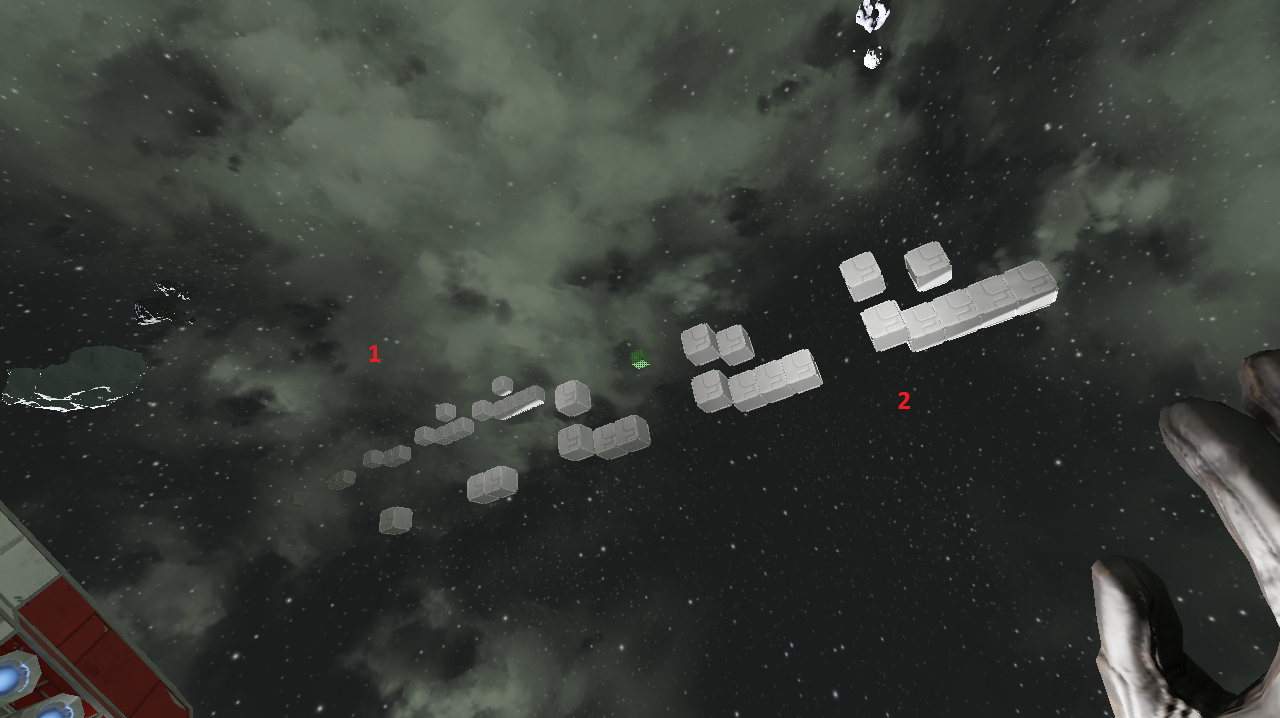

In [15]:
rules = RuleMaker(ruleset='rules').get_rules()

parser = LParser(rules=rules)

solver = LSolver(atoms_alphabet=atoms_alphabet,
                 parser=parser)

In [16]:
base_position, orientation_forward, orientation_up = get_base_values()

for i in range(5):
    print(f'Iteration {i}...')
    origin_position = base_position.sum(Vec.v3f(i*3, 0., 0.))
    
    structure = Structure(origin=origin_position,
                          orientation_forward=orientation_forward,
                          orientation_up=orientation_up,
                          dimensions=(5, 5, 5))
    
    axiom = solver.solve('B', i)
    
    print(f'\t-> Axiom: {axiom}')
    
    solver.fill_structure(structure=structure,
                          axiom=axiom)
    
    blocks = structure.get_all_blocks()
        
    place_blocks(blocks)

Iteration 0...
	-> Axiom: B
Iteration 1...
	-> Axiom: b+[>B]+
Iteration 2...
	-> Axiom: <b!!b??>+[>b+[>B]+]+
Iteration 3...
	-> Axiom: <b>+[><b>+[>b+[>B]+]+]+
Iteration 4...
	-> Axiom: <b>+[><b>+[><b!!b??>+[>b+[>B]+]+]+]+
